In [482]:
import pandas as pd 
import networkx as nx 
from cdlib import algorithms
import numpy as np
from matplotlib import pyplot as plt
import sknetwork as skn
from sknetwork.embedding import Spectral
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import torch 
from sklearn.calibration import CalibrationDisplay


In [4]:
ess = pd.read_csv('../data/G-HumanEssential.tsv', sep='\t')
ess.head()

,Gene ID,Essentiality (determined from multiple datasets),Data Source
0,122809,Non-essential,"PMID:26472758,PMID:26472760,PMID:18239125"
1,64359,Non-essential,"PMID:26472758,PMID:26472760,PMID:18239125"
2,11218,Essential,"PMID:26472758,PMID:26472760,PMID:18239125,PMID..."
3,401236,Non-essential,PMID:26472758
4,27115,Non-essential,"PMID:26472758,PMID:26472760,PMID:18239125"


In [11]:
ess.shape

(18528, 3)

In [22]:
ppi = pd.read_csv('../data/PP-Decagon_ppi.csv', sep=',', header=None).rename({0:'source', 1:'target'}, axis=1)
ppi.head()

,source,target
0,114787,375519
1,114787,285613
2,114787,7448
3,114787,4914
4,114787,51343


In [ ]:
proteins = set(ppi.values.reshape(-1))
genes = set(ess['Gene ID'].values)
shared = proteins.intersection(genes)


In [24]:
ppi_shared = ppi[lambda x: (x.source.isin(shared) & x.target.isin(shared))]
len(ppi_shared)

650272

In [25]:
G = nx.from_pandas_edgelist(ppi_shared)
len(G)

17261

In [30]:
largest_comp = next(iter(nx.connected_components(G)))
len(largest_comp)

17246

In [32]:
ppi_shared2 = ppi_shared[lambda x: (x.source.isin(largest_comp) & x.target.isin(largest_comp))]
len(ppi_shared2)

650264

In [35]:
G2 = nx.from_pandas_edgelist(ppi_shared2)
len(G2)

17246

In [39]:
coms = algorithms.infomap(G2) 

In [43]:
for i,com in enumerate(coms.communities): 
    if len(com) > 50: print(f'community {i}: size: {len(com)} | density: {nx.density(G2.subgraph(com)):.2f} | avg. cluster coef.: {np.array(list(nx.cluster.clustering(G2.subgraph(com)).values())).mean():.3f}')

community 0: size: 7097 | density: 0.01 | avg. cluster coef.: 0.260
community 1: size: 641 | density: 0.02 | avg. cluster coef.: 0.104
community 2: size: 620 | density: 0.07 | avg. cluster coef.: 0.453
community 3: size: 579 | density: 0.08 | avg. cluster coef.: 0.560
community 4: size: 470 | density: 0.27 | avg. cluster coef.: 0.817
community 5: size: 327 | density: 0.06 | avg. cluster coef.: 0.565
community 6: size: 308 | density: 0.48 | avg. cluster coef.: 0.868
community 7: size: 297 | density: 0.13 | avg. cluster coef.: 0.539
community 8: size: 293 | density: 0.14 | avg. cluster coef.: 0.595
community 9: size: 263 | density: 0.22 | avg. cluster coef.: 0.740
community 10: size: 221 | density: 0.05 | avg. cluster coef.: 0.328
community 11: size: 216 | density: 0.08 | avg. cluster coef.: 0.545
community 12: size: 215 | density: 0.23 | avg. cluster coef.: 0.729
community 13: size: 192 | density: 0.15 | avg. cluster coef.: 0.532
community 14: size: 164 | density: 0.19 | avg. cluster co

In [503]:
mycom = coms.communities[1]
ppi_small = ppi_shared[lambda x: (x.source.isin(mycom) & x.target.isin(mycom))]
ess_small = ess[lambda x: x['Gene ID'].isin(mycom)]
print('ppi edges:', len(ppi_small))
print('ess nodes:', len(ess_small))

ppi edges: 3378
ess nodes: 641


In [504]:
G_small = nx.from_pandas_edgelist(ppi_small)
A = nx.adjacency_matrix(G_small)
nodes = list(G_small.nodes())

In [505]:
x_df = pd.DataFrame(nodes, columns=['node_order']).reset_index().merge(ess_small, left_on='node_order', right_on='Gene ID').assign(ess = lambda x: [float(y == 'Essential') for y in x['Essentiality (determined from multiple datasets)']])
x_df.head()

,index,node_order,Gene ID,Essentiality (determined from multiple datasets),Data Source,ess
0,0,114789,114789,Non-essential,"PMID:26472758,PMID:26472760,PMID:18239125,PMID...",0.0
1,1,6564,6564,Non-essential,"PMID:26472758,PMID:26472760,PMID:18239125",0.0
2,2,79085,79085,Non-essential,"PMID:26472758,PMID:26472760,PMID:18239125",0.0
3,3,974,974,Non-essential,"PMID:26472758,PMID:26472760,PMID:18239125",0.0
4,4,961,961,Non-essential,"PMID:26472758,PMID:26472760,PMID:18239125",0.0


In [506]:
x_df.groupby(['Essentiality (determined from multiple datasets)']).count()

,index,node_order,Gene ID,Data Source,ess
Essentiality (determined from multiple datasets),,,,,
Essential,13,13,13,13,13
Non-essential,628,628,628,628,628


In [507]:
x_df.ess.sum()

13.0

In [508]:
#pos = nx.spring_layout(G_small)

In [509]:
#plt.figure(figsize=(12,12))
#nx.draw_networkx_nodes(G_small, node_color=x_df.ess, pos=pos, alpha=0.5)
#nx.draw_networkx_edges(G_small, pos=pos, alpha=0.1)

In [510]:
spectral = Spectral(10) 
embed = spectral.fit_transform(A)

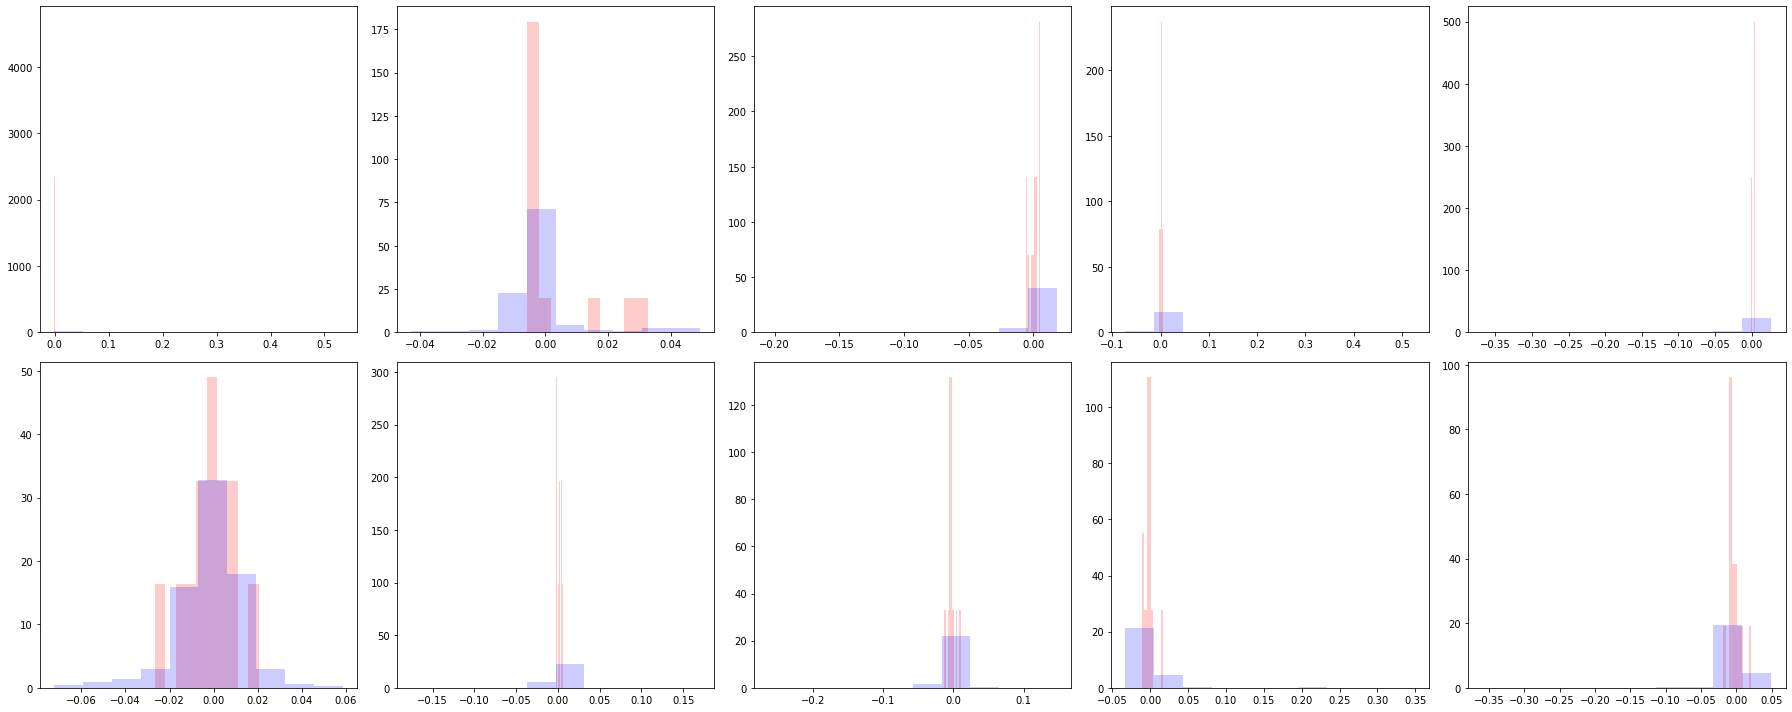

In [512]:
f,axes = plt.subplots(2,5, figsize=(25,10), sharex=False, sharey=False)
for u, ax in zip(embed.T, axes.flat):
    ax.hist(u[(x_df.ess == 1)], color='r', alpha=0.2, density=True)
    ax.hist(u[(x_df.ess == 0)], color='b', alpha=0.2, density=True)

plt.tight_layout()
plt.show()

In [513]:
X = embed 
y = x_df.ess.values

train_mask = np.random.choice([True, False], p=[0.8, 0.2], size=y.shape[0])
test_mask = ~train_mask 

print('training positive examples:', y[train_mask].sum())
print('testing positive examples:', y[test_mask].sum())

clf = SVC(gamma='auto', class_weight='balanced').fit(X[train_mask], y[train_mask])
clf.score(X[test_mask], y[test_mask])

training positive examples: 10.0
testing positive examples: 3.0


0.9772727272727273

In [514]:
yhat = clf.predict(X)
yhat.sum()

0.0

# Graph Neural Network 

In [515]:
A = A.todense()

In [809]:
class GNN(torch.nn.Module): 
    def __init__(self, input, channels, normalize=True, cache=True, dropout=0.0): 
        super(GNN, self).__init__() 


        self.f1 = torch.nn.Linear(input, channels)
        self.f2 = torch.nn.Linear(channels, channels)
        self.f3 = torch.nn.Linear(channels, channels)
        self.f_out = torch.nn.Sequential(torch.nn.Linear(channels, channels), torch.nn.ReLU(), torch.nn.Linear(channels, 1))
        self.nonlin = torch.nn.ReLU()
        self.norm = None
        self.cache = cache
        self.do = torch.nn.Dropout(dropout)
        self.bn = torch.nn.BatchNorm1d(channels)
        self.normalize=normalize

    def norm_adj(self, A): 
        '''
        normalize by GCN method
        '''
        #D = torch.eye(A.size(0)) * A.sum(axis=1)
        Dinv = torch.diag_embed(torch.pow(A.sum(dim=-1),-0.5))
        return Dinv @ A @ Dinv

    def forward(self, A, x):  

        
        A = self.norm_adj(A)
        
        h1 = self.nonlin((A @ self.f1(x)))    # what neighborhood size does this embedding contain?
        #h1 = self.bn(h1)
        h1 = self.do(h1)
        h2 = self.nonlin((A @ self.f2(h1)))
        #h2 = self.bn(h2)
        h2 = self.do(h2)
        h3 = self.nonlin((A @ self.f3(h2)))
        #h3 = self.bn(h3)
        h3 = self.do(h3)
        return torch.sigmoid( self.f_out(h3) ).squeeze()

In [810]:
model = GNN(1, 75, normalize=True, cache=True, dropout=0.1)

y = torch.tensor(x_df.ess.values, dtype=torch.float)
x = torch.ones_like(y).unsqueeze(-1)
A = torch.tensor(A, dtype=torch.float)

# self connections
A[torch.eye(A.size(0), dtype=torch.bool)] = 1

train_mask = torch.tensor(train_mask, dtype=torch.bool)
test_mask = torch.tensor(test_mask, dtype=torch.bool)

In [811]:
weights = torch.ones_like(y[train_mask])
n_neg = (y[train_mask] == 0).sum()
n_pos = (y[train_mask] == 1).sum()
weights[y[train_mask] == 1] = n_neg / n_pos

In [812]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
crit = torch.nn.BCELoss(reduction='none')

In [813]:
model = model.train()
test_roc = []
train_roc = []
test_acc = [] 
train_acc = []
mean_window=10

for epoch in range(2000): 
    optim.zero_grad()
    yhat = model(A, x)
    losses = crit(yhat[train_mask], y[train_mask])
    loss = (losses*weights).mean()
    #l2 = (yhat[train_mask].mean() - 0.5)**2
    #loss += l2 
    loss.backward() 
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optim.step()

    with torch.no_grad(): 
        yhat = model(A, x)
        #precision, recall, _, _  = precision_recall_fscore_support(y[test_mask].detach().numpy(), yhat[test_mask].detach().numpy() > 0.5, average='binary')
        train_roc.append( roc_auc_score(y[train_mask].detach().numpy(), yhat[train_mask].detach().numpy()) )
        test_roc.append( roc_auc_score(y[test_mask].detach().numpy(), yhat[test_mask].detach().numpy()) )
        train_acc.append((1.*((yhat[train_mask] > 0.5) == y[train_mask])).mean().item())
        test_acc.append((1.*((yhat[test_mask] > 0.5) == y[test_mask])).mean().item())
        if epoch > mean_window: print(f'EPOCH: {epoch} || test acc: {np.mean(test_acc[-mean_window:])} || roc: {np.mean(test_roc[-mean_window:]):.2f}', end='\r')

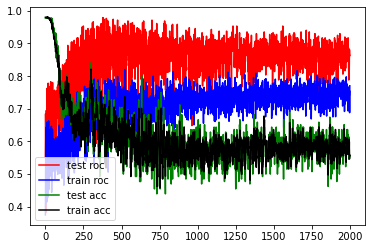

In [814]:
plt.figure()
plt.plot(test_roc, 'r-', label='test roc')
plt.plot(train_roc, 'b-', label='train roc')
plt.plot(test_acc, 'g-', label='test acc')
plt.plot(train_acc, 'k-', label='train acc')
#plt.yscale('log')
plt.legend()
plt.show()

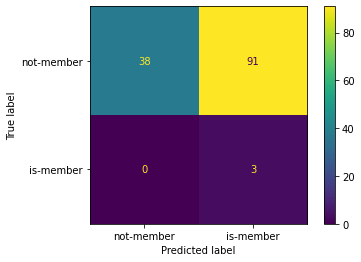

In [815]:
model = model.eval()
yhat = model(A, x)

cm = confusion_matrix(y[test_mask].detach().numpy(), yhat[test_mask].detach().numpy() > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not-member', 'is-member'])
disp.plot()

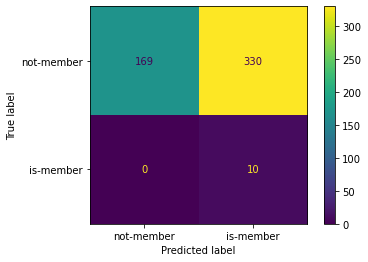

In [816]:
cm = confusion_matrix(y[train_mask].detach().numpy(), yhat[train_mask].detach().numpy() > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not-member', 'is-member'])
disp.plot()

<Figure size 432x288 with 0 Axes>

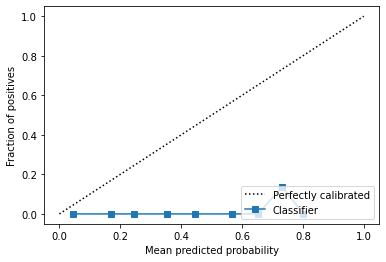

In [788]:
plt.figure()
disp = CalibrationDisplay.from_predictions(y[test_mask].detach().numpy(), yhat[test_mask].detach().numpy(), n_bins=10)
plt.show()

<Figure size 432x288 with 0 Axes>

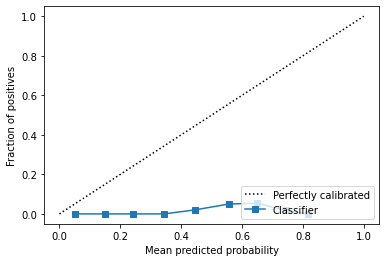

In [789]:
plt.figure()
disp = CalibrationDisplay.from_predictions(y[train_mask].detach().numpy(), yhat[train_mask].detach().numpy(), n_bins=10)
plt.show()

In [768]:
yhat.mean()

tensor(0.3774, grad_fn=<MeanBackward0>)

In [359]:
crit(yhat[train_mask], y[train_mask])

tensor(14.4444, grad_fn=<BinaryCrossEntropyBackward0>)